# Linear Models

## Load Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import time


In [16]:
images_train = np.load("../data/images/images_train.npy")
images_test = np.load("../data/images/images_test.npy")
num_samples_train = images_train.shape[0]
num_samples_test = images_test.shape[0]

images_train = images_train.reshape(num_samples_train, -1)
images_test = images_test.reshape(num_samples_test, -1)

hog_train = np.load("../data/hog/hog_train.npy").reshape(num_samples_train, -1)
hog_train = hog_train * 255
hog_test = np.load("../data/hog/hog_test.npy").reshape(num_samples_test, -1)
hog_test = hog_test * 255

canny_edges_train  = np.load("../data/canny_edges/canny_edges_train.npy").reshape(num_samples_train, -1)
canny_edges_test  = np.load("../data/canny_edges/canny_edges_test.npy").reshape(num_samples_test, -1)

contours_train = np.load("../data/contours/contours_train.npy").reshape(num_samples_train, -1)
contours_test = np.load("../data/contours/contours_test.npy").reshape(num_samples_test, -1)

imagenet_train = np.load("../data/vgg19/vgg19_train.npy").reshape(num_samples_train, -1)
imagenet_test = np.load("../data/vgg19/vgg19_test.npy").reshape(num_samples_test, -1)

pca_train = np.load("../data/pca/pca_train.npy")
pca_test = np.load("../data/pca/pca_test.npy")

y_train = np.load("../data/images/label_ids_train.npy")
y_test = np.load("../data/images/label_ids_test.npy")

train_indices = np.random.permutation(num_samples_train)
images_train = images_train[train_indices]
hog_train = hog_train[train_indices]
canny_edges_train = canny_edges_train[train_indices]
contours_train = contours_train[train_indices]
imagenet_train = imagenet_train[train_indices]
pca_train = pca_train[train_indices]
y_train = y_train[train_indices]

test_indices = np.random.permutation(num_samples_test)
images_test = images_test[test_indices]
hog_test = hog_test[test_indices]
canny_edges_test = canny_edges_test[test_indices]
contours_test = contours_test[test_indices]
imagenet_test = imagenet_test[test_indices]
pca_test = pca_test[test_indices]
y_test = y_test[test_indices]


In [3]:
labels_train = np.load("../data/images/labels_train.npy")
class_lookup = list(set(zip(y_train, labels_train)))
class_lookup = {id_value: class_value for id_value, class_value in class_lookup}
class_lookup
sorted_class_lookup = {k: class_lookup[k] for k in sorted(class_lookup)}
label_names = list(sorted_class_lookup.values())

In [4]:
def show_confusion_matrix(confusion_matrix):
  ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                  xticklabels=label_names, yticklabels=label_names, cbar=False)

  # Add axis labels.
  ax.set(xlabel='Predicted Label', ylabel='True Label')
  plt.show()

In [5]:
def show_roc_curve(y_score, y_test):
  # Binarize the output
  y_test_bin = label_binarize(y_test, classes=list(range(10)))
  n_classes = y_test_bin.shape[1]
  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  for i in range(n_classes):
      plt.figure()
      plt.plot(fpr[i], tpr[i], color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc[i]:.2f})')
      plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title(f'Receiver Operating Characteristic for {label_names[i]}')
      plt.legend(loc="lower right")
      plt.show()

## Model 1: Images Only

In [6]:
model = LogisticRegression(max_iter=1000, multi_class='auto', solver='lbfgs')
model.fit(images_train, y_train)


/home/davidsolow/.pyenv/versions/3.11.1/envs/fracture-classification/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='auto')

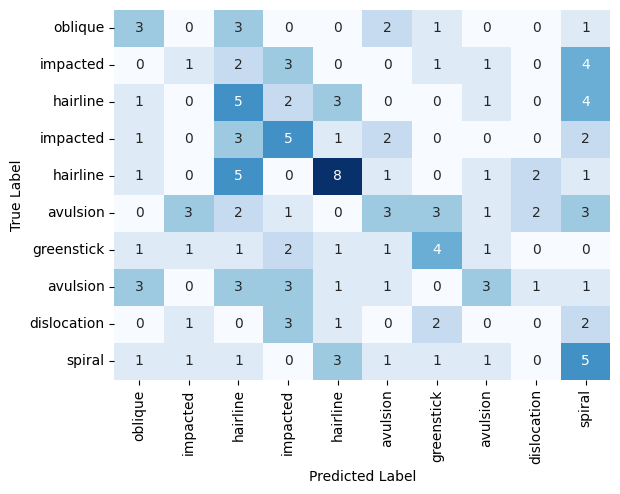

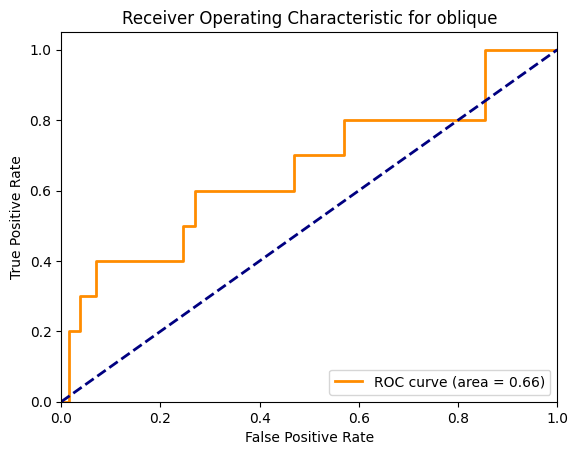

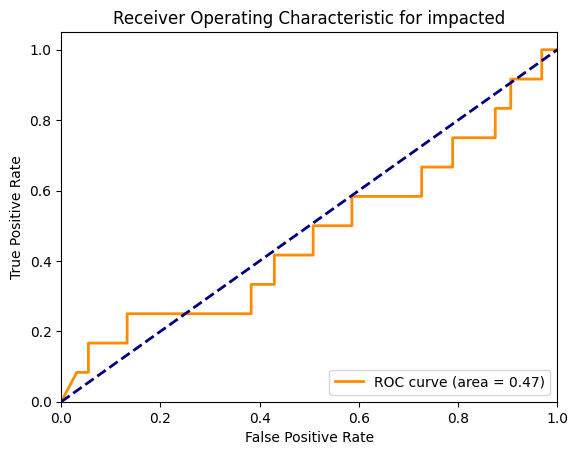

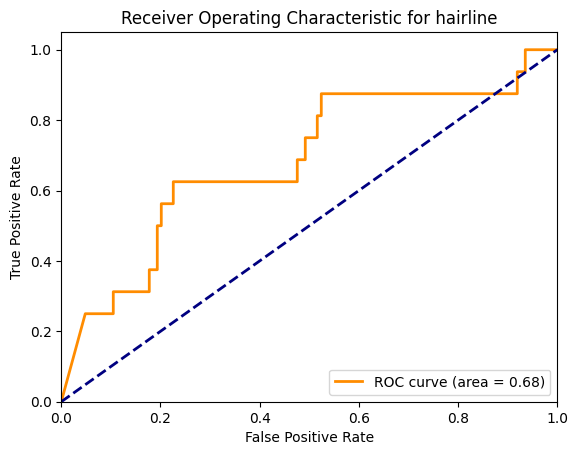

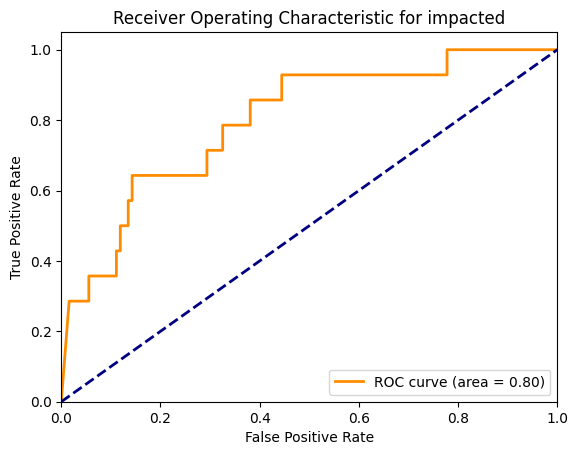

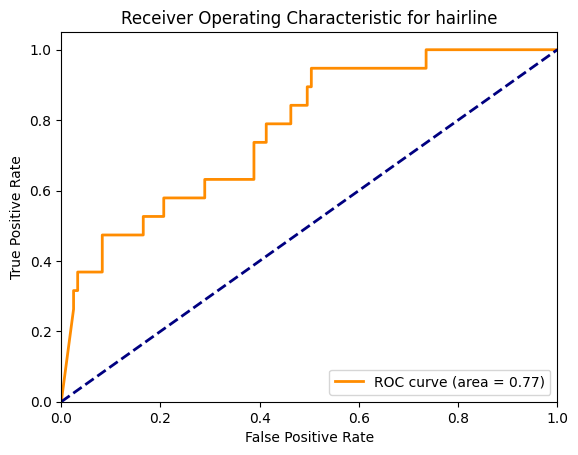

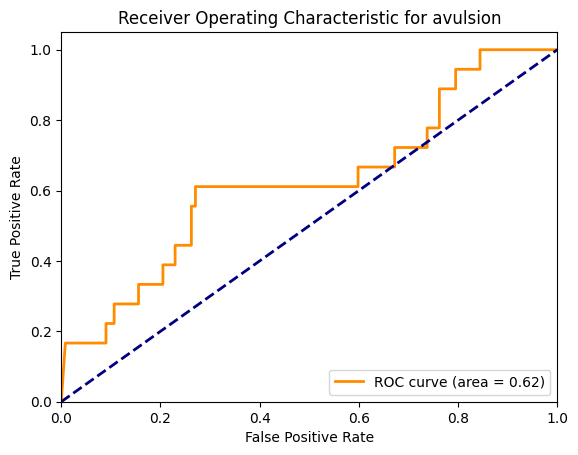

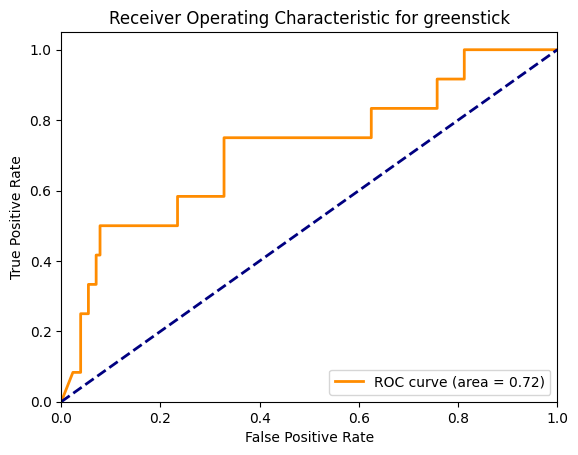

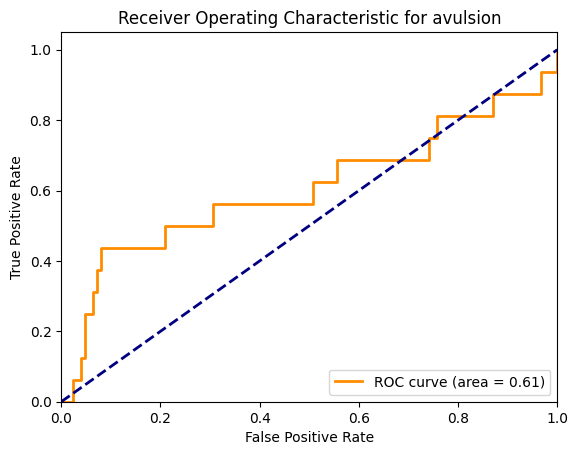

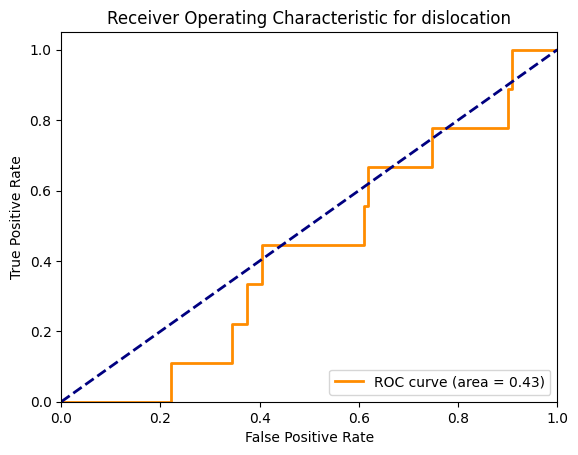

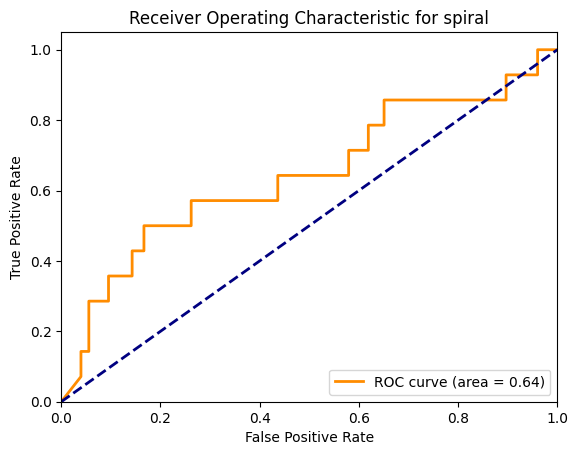

Accuracy: 0.2642857142857143
Classification Report:


,precision,recall,f1-score,support
oblique,0.272727,0.300000,0.285714,10.000000
impacted,0.142857,0.083333,0.105263,12.000000
hairline,0.200000,0.312500,0.243902,16.000000
impacted,0.263158,0.357143,0.303030,14.000000
hairline,0.444444,0.421053,0.432432,19.000000
avulsion,0.272727,0.166667,0.206897,18.000000
greenstick,0.333333,0.333333,0.333333,12.000000
avulsion,0.333333,0.187500,0.240000,16.000000
dislocation,0.000000,0.000000,0.000000,9.000000
spiral,0.217391,0.357143,0.270270,14.000000


In [7]:
y_pred = model.predict(images_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report.index = report.index.map(lambda x: class_lookup[int(x)] if x.isdigit() else x)

test_confusion_matrix = confusion_matrix(y_test, y_pred)
show_confusion_matrix(test_confusion_matrix)

y_score = model.predict_proba(images_test)
show_roc_curve(y_score, y_test)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
report


## Model 2: HOG Feature Only

In [8]:
model = LogisticRegression(max_iter=1000, multi_class='auto', solver='lbfgs')
model.fit(hog_train, y_train)


/home/davidsolow/.pyenv/versions/3.11.1/envs/fracture-classification/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='auto')

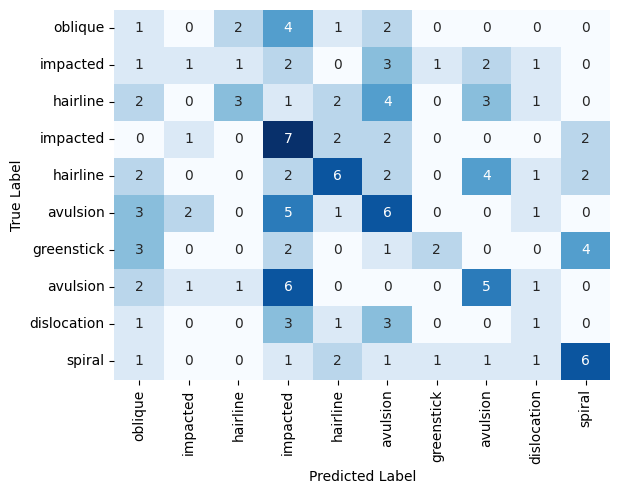

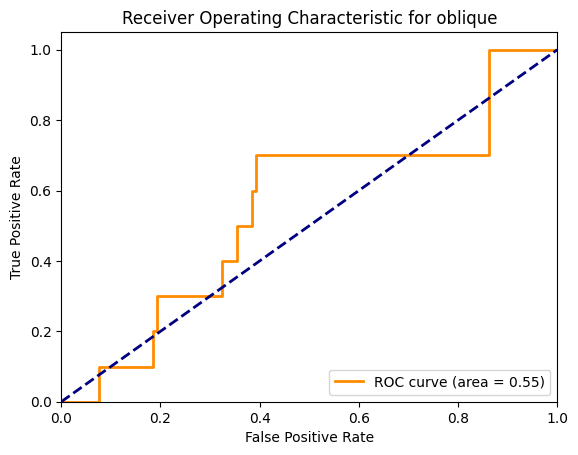

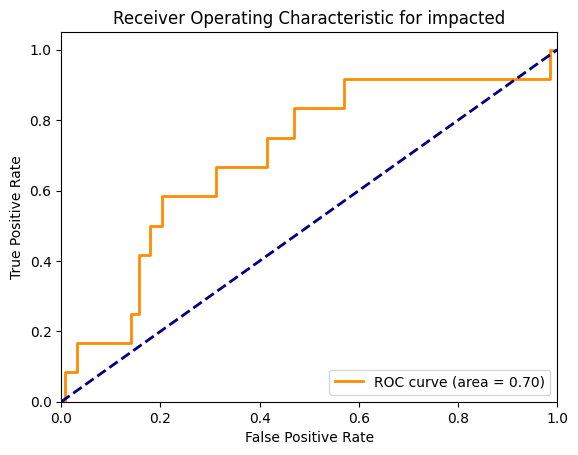

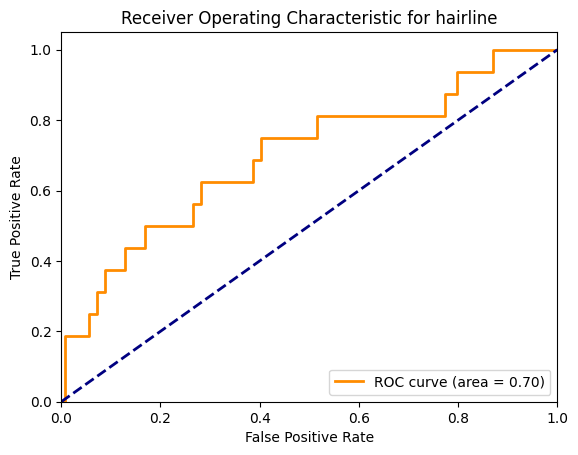

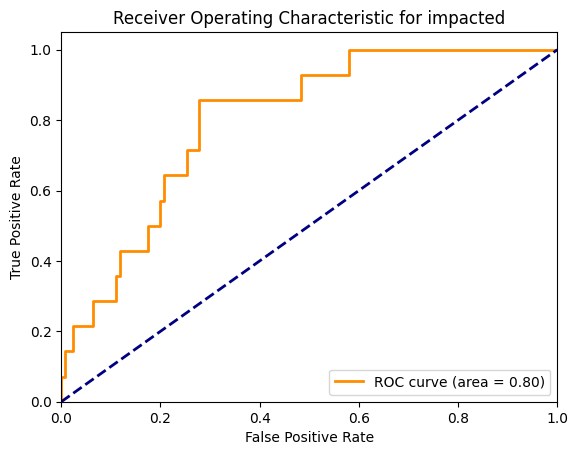

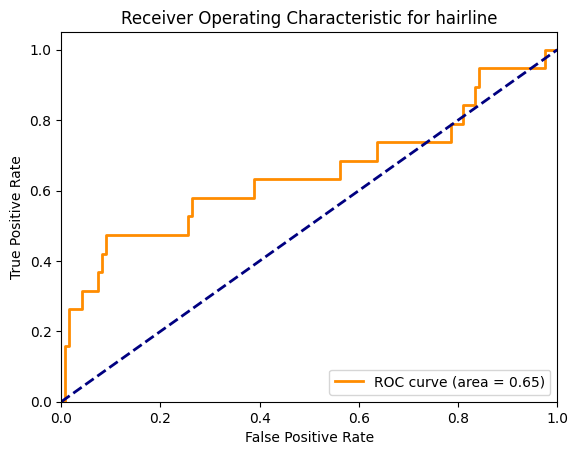

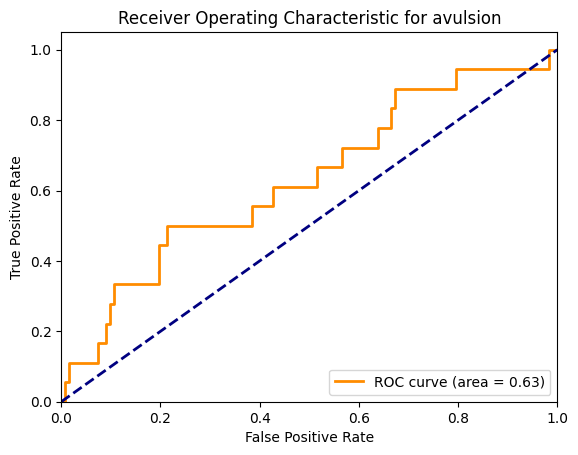

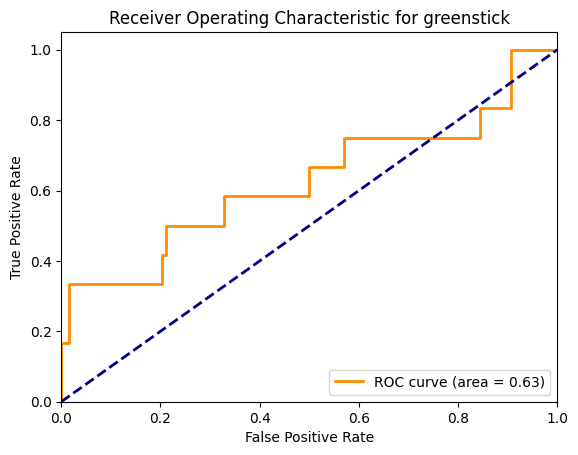

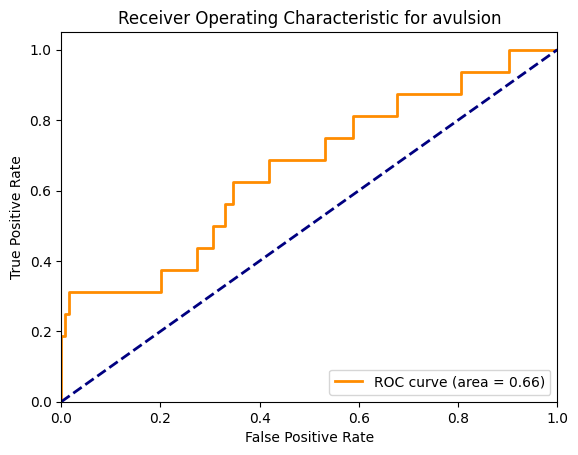

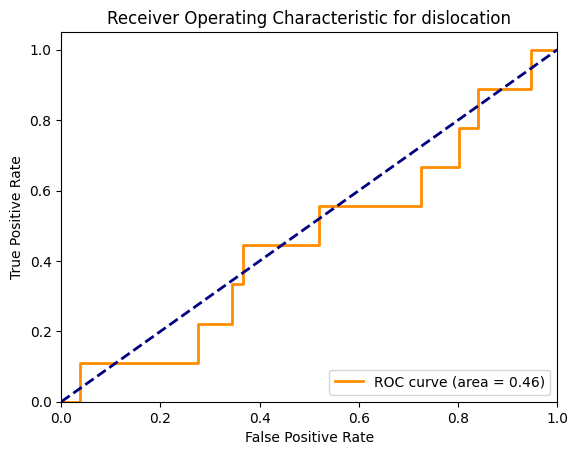

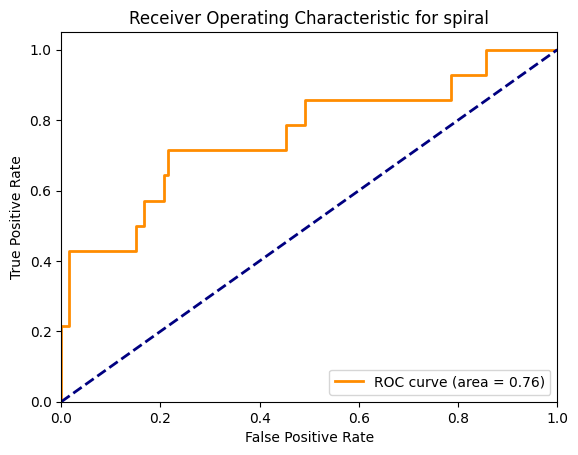

Accuracy: 0.2714285714285714
Classification Report:


,precision,recall,f1-score,support
oblique,0.062500,0.100000,0.076923,10.000000
impacted,0.200000,0.083333,0.117647,12.000000
hairline,0.428571,0.187500,0.260870,16.000000
impacted,0.212121,0.500000,0.297872,14.000000
hairline,0.400000,0.315789,0.352941,19.000000
avulsion,0.250000,0.333333,0.285714,18.000000
greenstick,0.500000,0.166667,0.250000,12.000000
avulsion,0.333333,0.312500,0.322581,16.000000
dislocation,0.142857,0.111111,0.125000,9.000000
spiral,0.428571,0.428571,0.428571,14.000000


In [9]:
y_pred = model.predict(hog_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report.index = report.index.map(lambda x: class_lookup[int(x)] if x.isdigit() else x)

test_confusion_matrix = confusion_matrix(y_test, y_pred)
show_confusion_matrix(test_confusion_matrix)

y_score = model.predict_proba(hog_test)
show_roc_curve(y_score, y_test)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
report

## Model 3: Canny Edges Feature Only

In [10]:
model = LogisticRegression(max_iter=1000, multi_class='auto', solver='lbfgs')
model.fit(canny_edges_train, y_train)


/home/davidsolow/.pyenv/versions/3.11.1/envs/fracture-classification/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='auto')

/home/davidsolow/.pyenv/versions/3.11.1/envs/fracture-classification/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/davidsolow/.pyenv/versions/3.11.1/envs/fracture-classification/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/davidsolow/.pyenv/versions/3.11.1/envs/fracture-classification/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use 

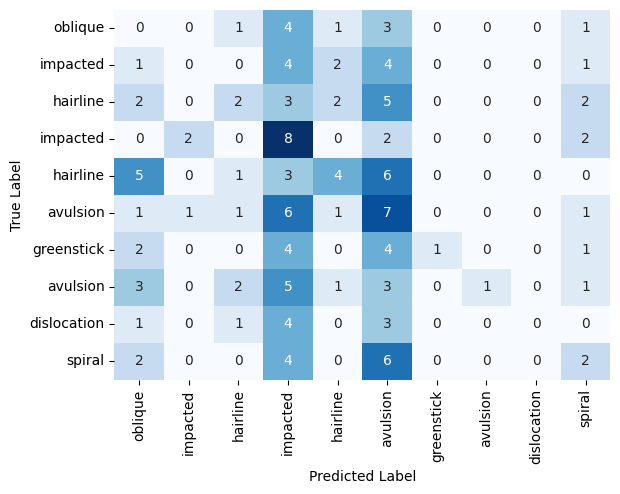

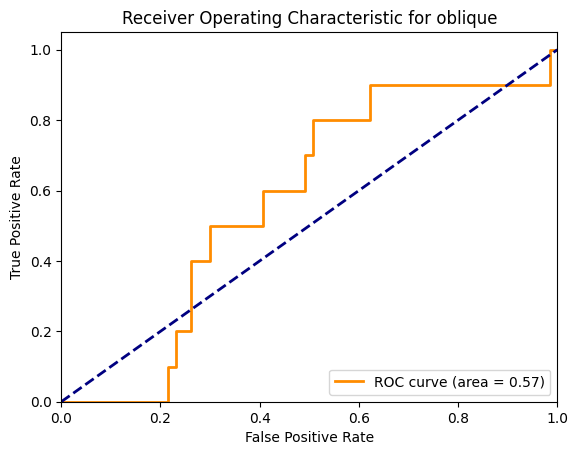

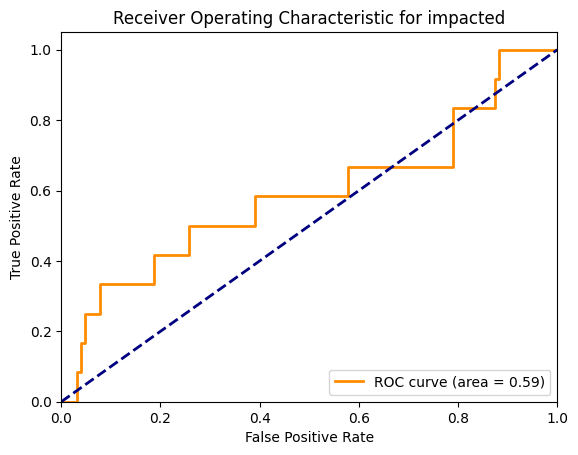

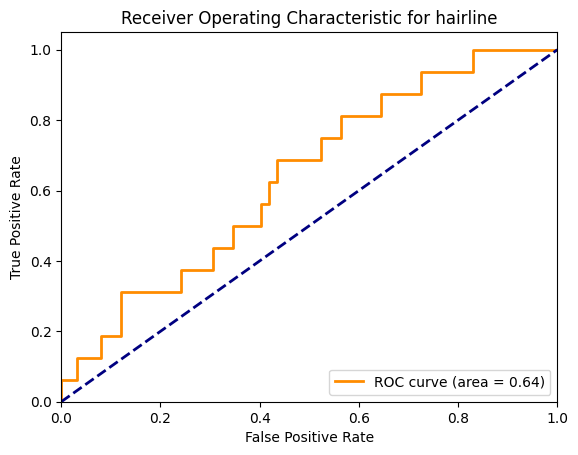

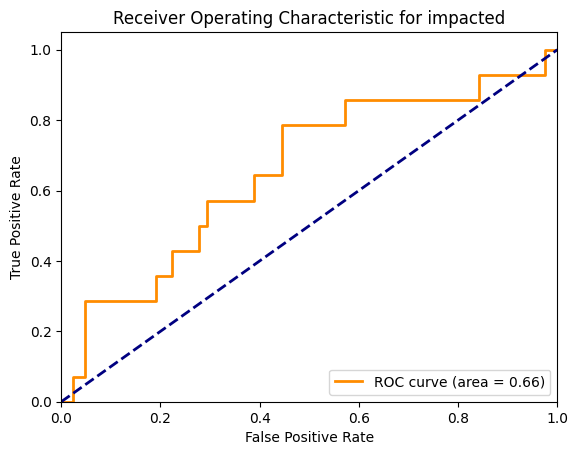

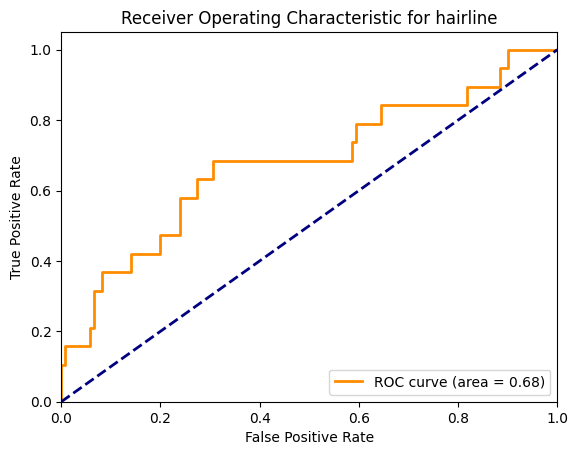

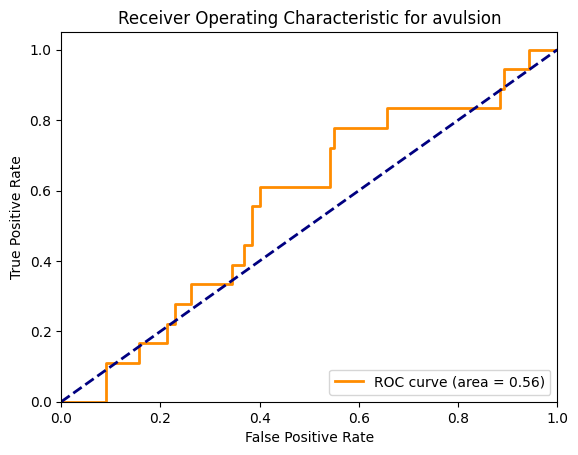

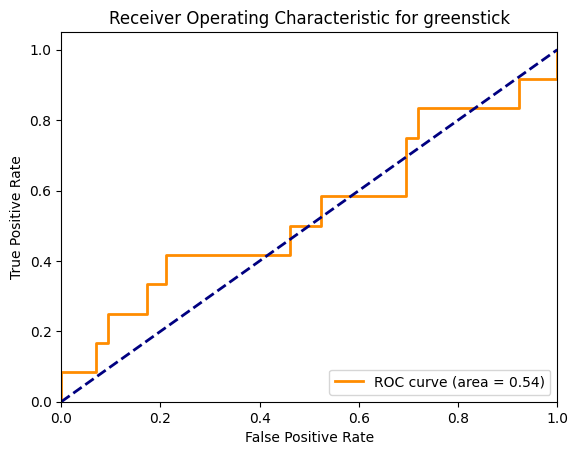

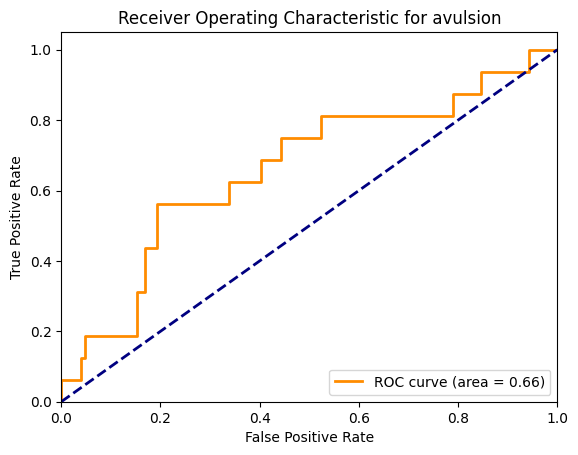

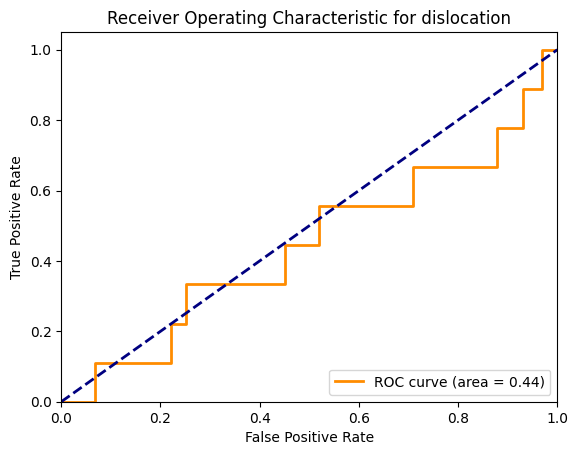

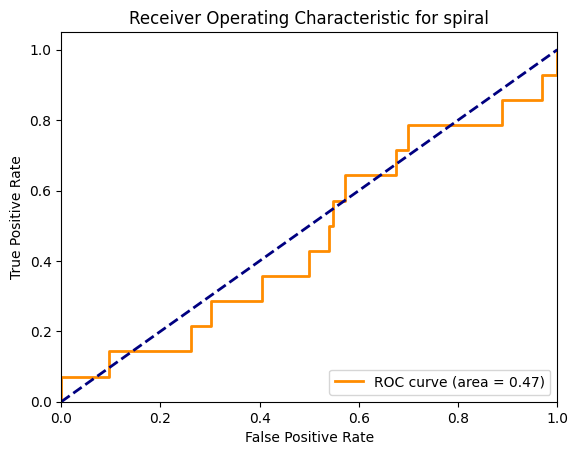

Accuracy: 0.17857142857142858
Classification Report:


,precision,recall,f1-score,support
oblique,0.000000,0.000000,0.000000,10.000000
impacted,0.000000,0.000000,0.000000,12.000000
hairline,0.250000,0.125000,0.166667,16.000000
impacted,0.177778,0.571429,0.271186,14.000000
hairline,0.363636,0.210526,0.266667,19.000000
avulsion,0.162791,0.388889,0.229508,18.000000
greenstick,1.000000,0.083333,0.153846,12.000000
avulsion,1.000000,0.062500,0.117647,16.000000
dislocation,0.000000,0.000000,0.000000,9.000000
spiral,0.181818,0.142857,0.160000,14.000000


In [11]:
y_pred = model.predict(canny_edges_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report.index = report.index.map(lambda x: class_lookup[int(x)] if x.isdigit() else x)

test_confusion_matrix = confusion_matrix(y_test, y_pred)
show_confusion_matrix(test_confusion_matrix)

y_score = model.predict_proba(canny_edges_test)
show_roc_curve(y_score, y_test)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
report

## Model 4: Contours Feature Only

In [12]:
model = LogisticRegression(max_iter=1000, multi_class='auto', solver='lbfgs')
model.fit(contours_train, y_train)


/home/davidsolow/.pyenv/versions/3.11.1/envs/fracture-classification/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='auto')

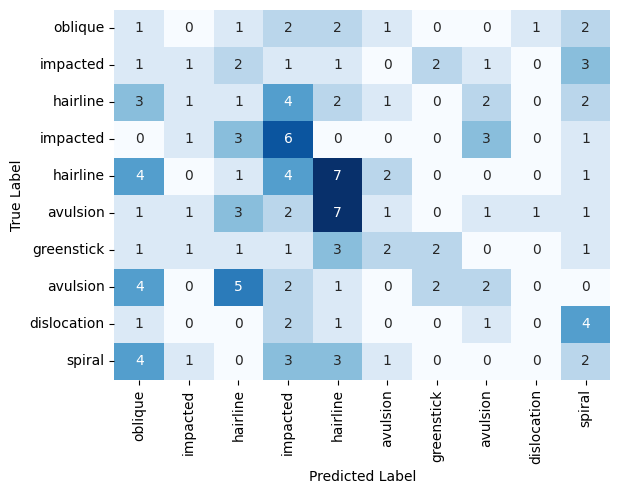

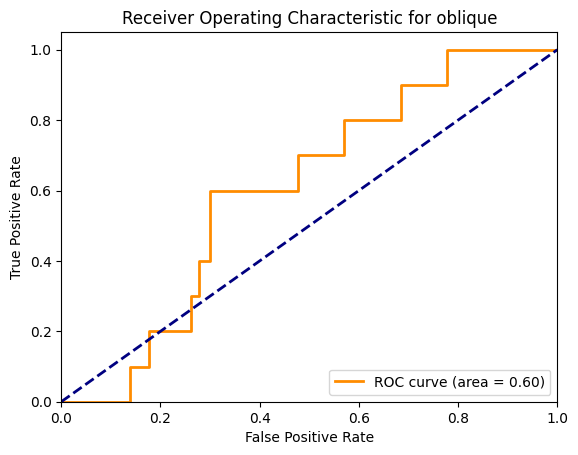

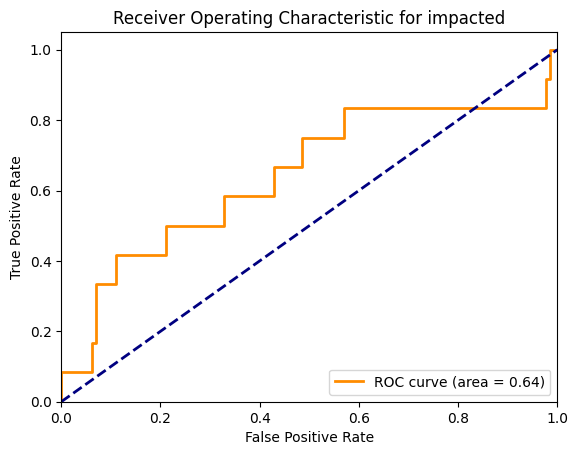

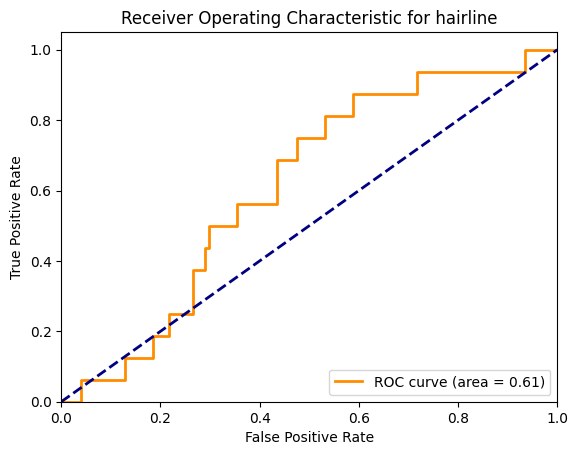

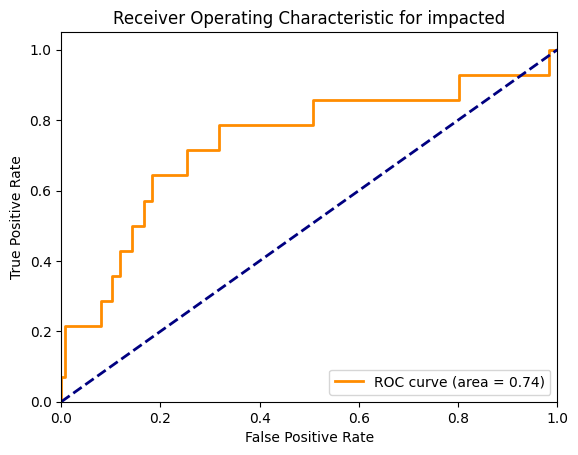

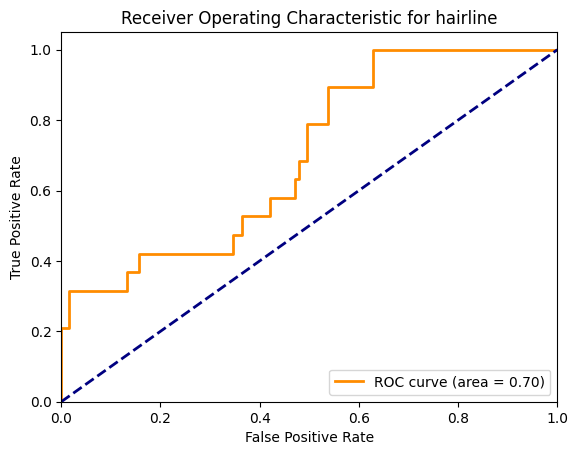

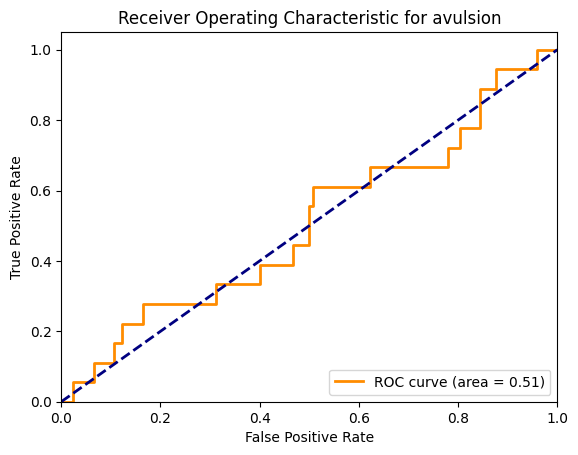

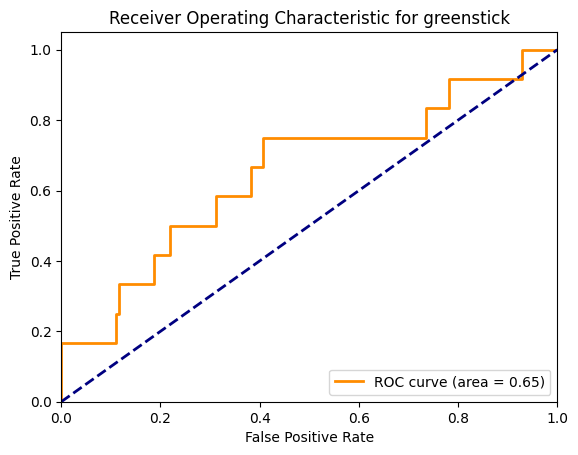

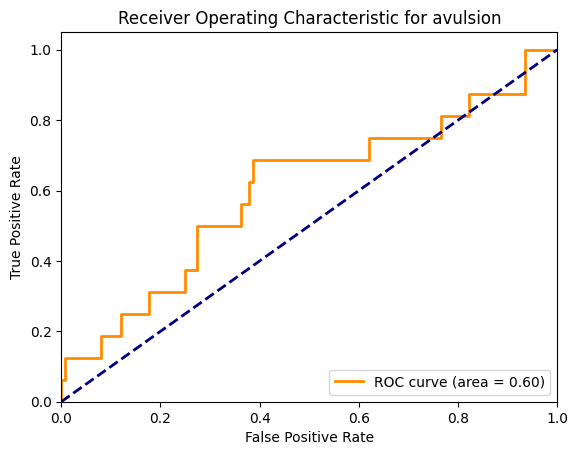

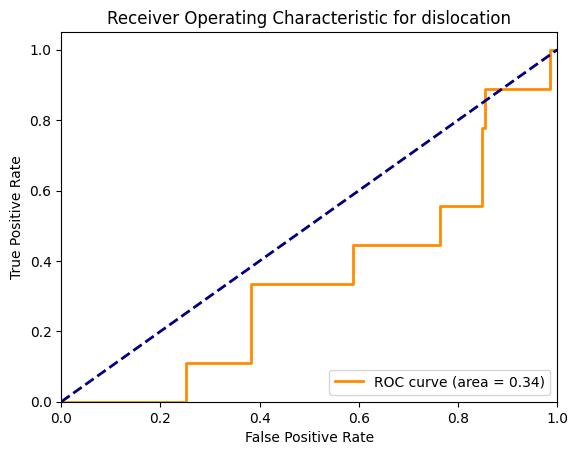

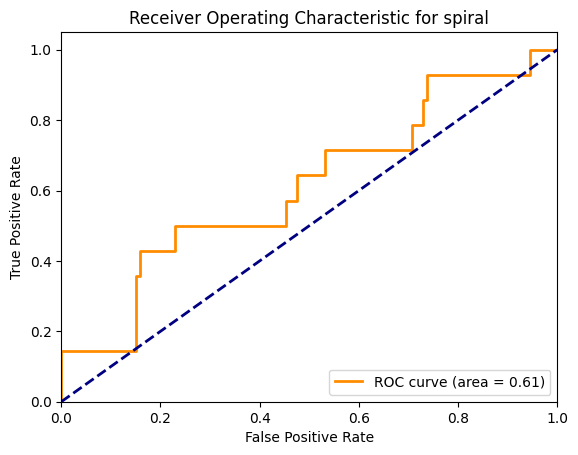

Accuracy: 0.16428571428571428
Classification Report:


,precision,recall,f1-score,support
oblique,0.050000,0.100000,0.066667,10.000000
impacted,0.166667,0.083333,0.111111,12.000000
hairline,0.058824,0.062500,0.060606,16.000000
impacted,0.222222,0.428571,0.292683,14.000000
hairline,0.259259,0.368421,0.304348,19.000000
avulsion,0.125000,0.055556,0.076923,18.000000
greenstick,0.333333,0.166667,0.222222,12.000000
avulsion,0.200000,0.125000,0.153846,16.000000
dislocation,0.000000,0.000000,0.000000,9.000000
spiral,0.117647,0.142857,0.129032,14.000000


In [13]:
y_pred = model.predict(contours_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report.index = report.index.map(lambda x: class_lookup[int(x)] if x.isdigit() else x)

test_confusion_matrix = confusion_matrix(y_test, y_pred)
show_confusion_matrix(test_confusion_matrix)

y_score = model.predict_proba(contours_test)
show_roc_curve(y_score, y_test)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
report

## Model 5: ImageNet Feature Only

In [17]:
model = LogisticRegression(max_iter=1000, multi_class='auto', solver='lbfgs')
model.fit(imagenet_train, y_train)


/home/davidsolow/.pyenv/versions/3.11.1/envs/fracture-classification/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='auto')

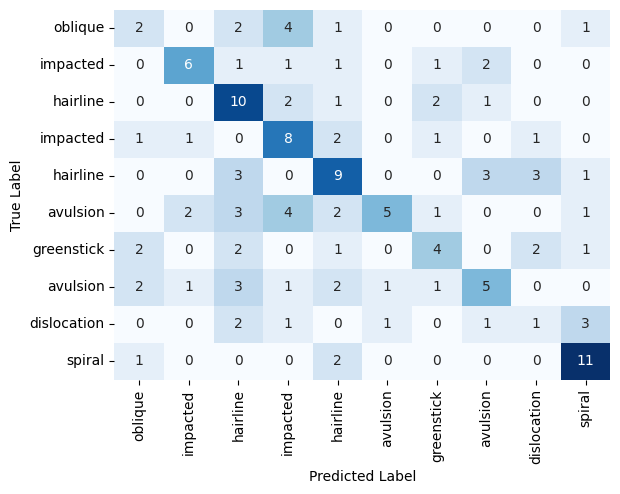

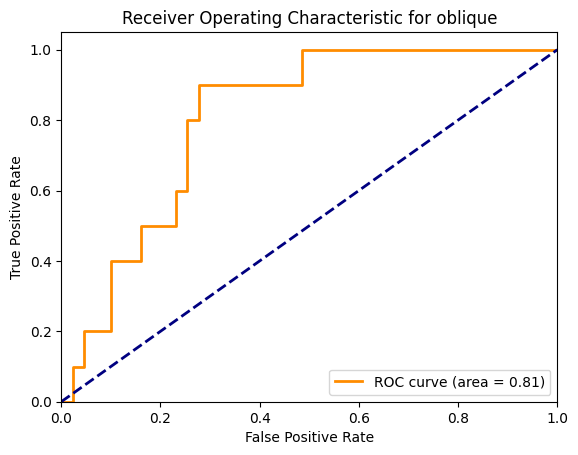

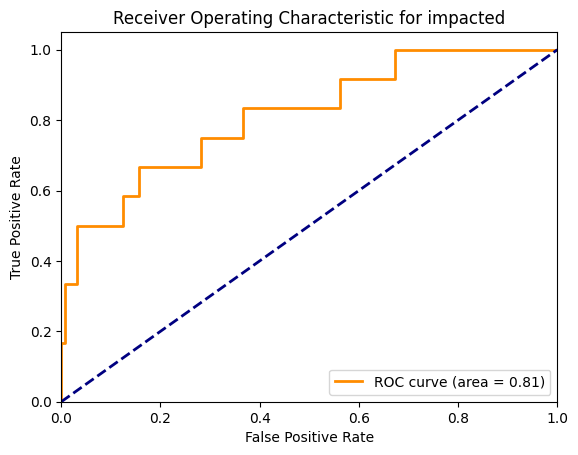

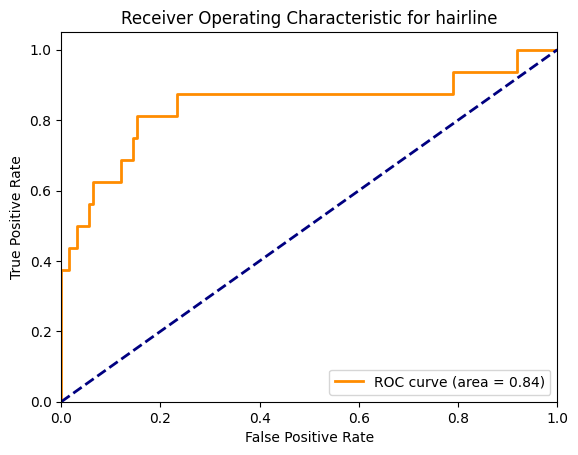

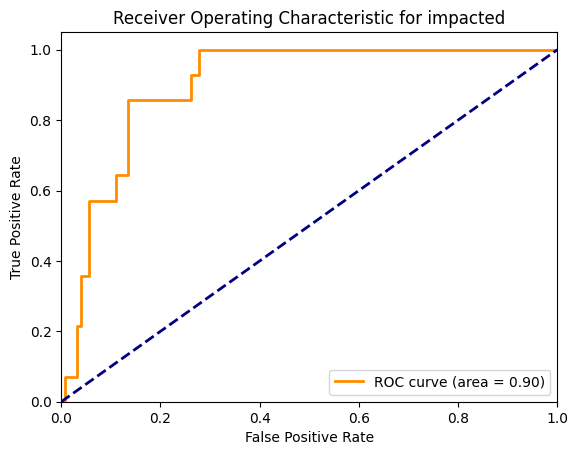

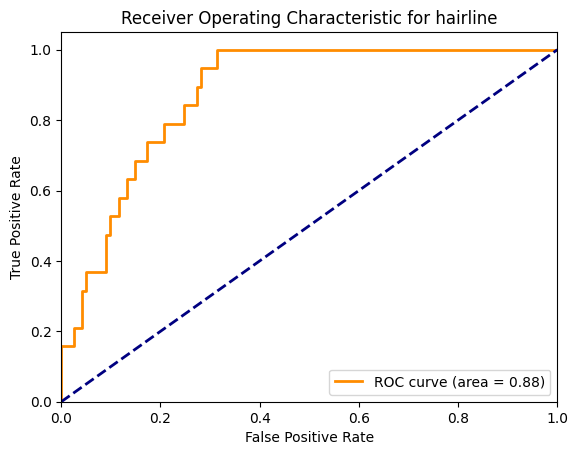

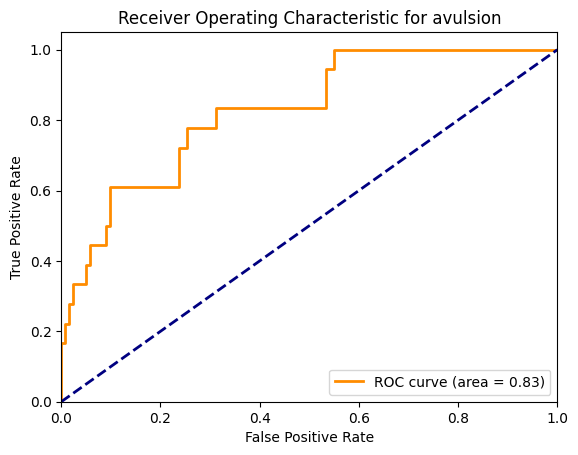

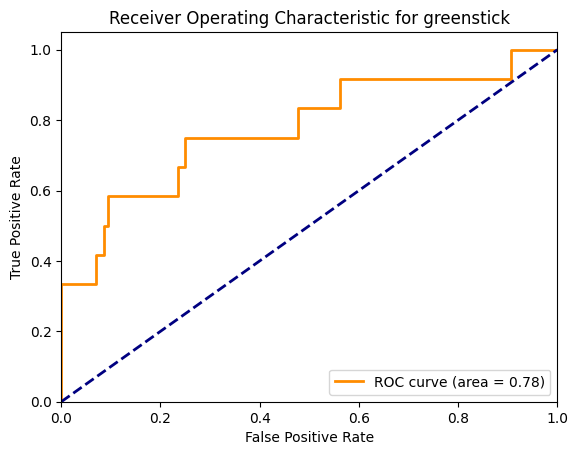

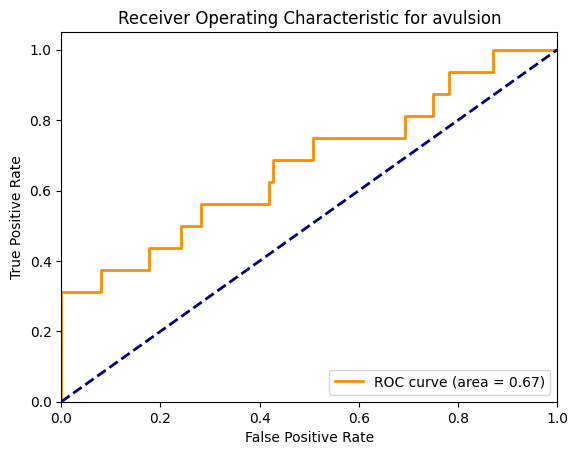

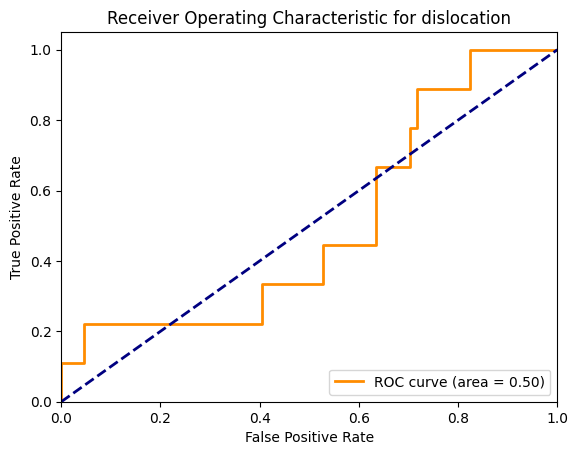

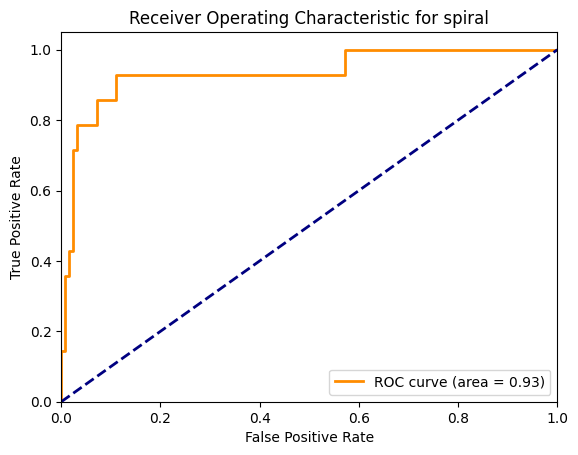

Accuracy: 0.4357142857142857
Classification Report:


,precision,recall,f1-score,support
oblique,0.250000,0.200000,0.222222,10.000000
impacted,0.600000,0.500000,0.545455,12.000000
hairline,0.384615,0.625000,0.476190,16.000000
impacted,0.380952,0.571429,0.457143,14.000000
hairline,0.428571,0.473684,0.450000,19.000000
avulsion,0.714286,0.277778,0.400000,18.000000
greenstick,0.400000,0.333333,0.363636,12.000000
avulsion,0.416667,0.312500,0.357143,16.000000
dislocation,0.142857,0.111111,0.125000,9.000000
spiral,0.611111,0.785714,0.687500,14.000000


In [18]:
y_pred = model.predict(imagenet_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report.index = report.index.map(lambda x: class_lookup[int(x)] if x.isdigit() else x)

test_confusion_matrix = confusion_matrix(y_test, y_pred)
show_confusion_matrix(test_confusion_matrix)

y_score = model.predict_proba(imagenet_test)
show_roc_curve(y_score, y_test)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
report

## Model 6: PCA Feature Only

In [19]:
model = LogisticRegression(max_iter=1000, multi_class='auto', solver='lbfgs')
model.fit(pca_train, y_train)


/home/davidsolow/.pyenv/versions/3.11.1/envs/fracture-classification/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/davidsolow/.pyenv/versions/3.11.1/envs/fracture-classification/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000, multi_class='auto')

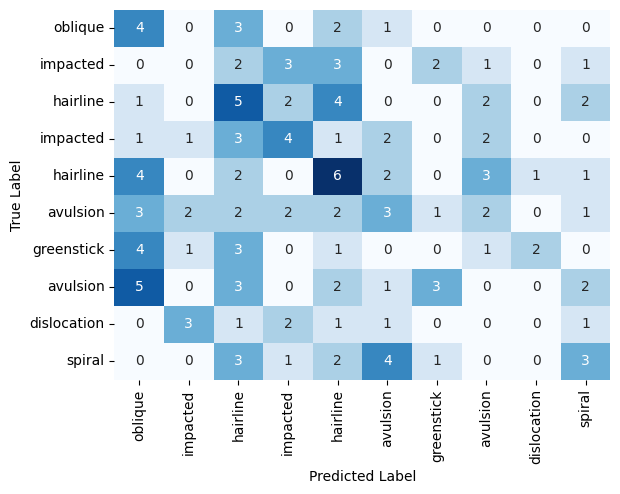

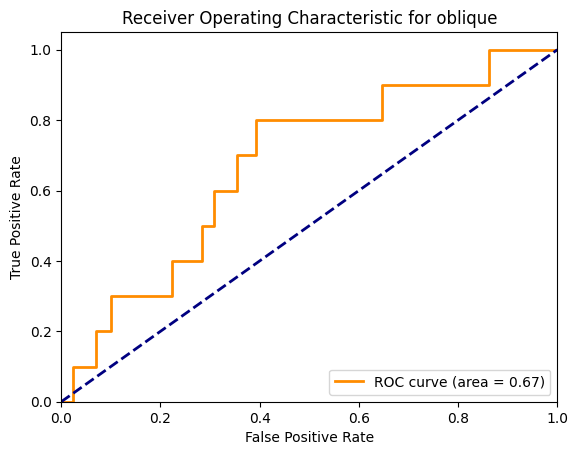

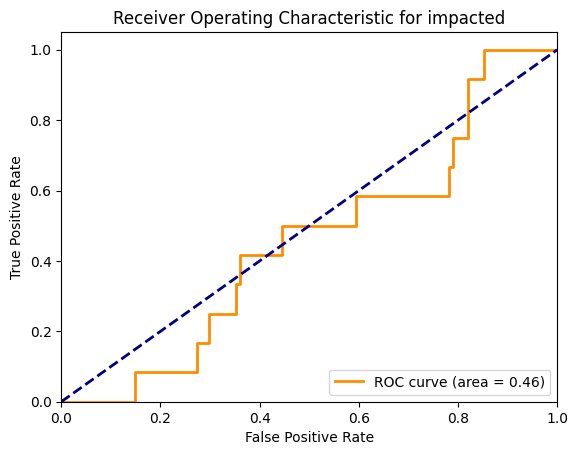

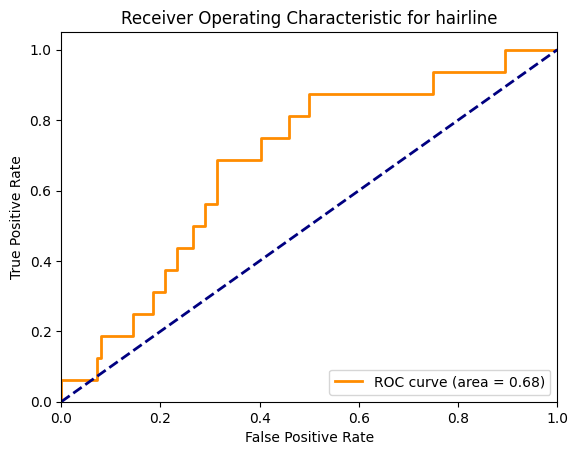

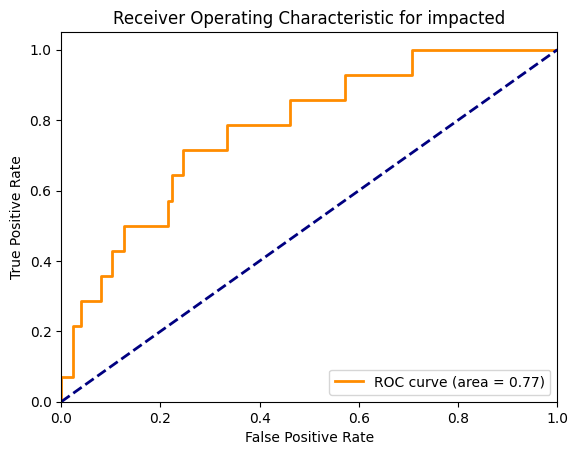

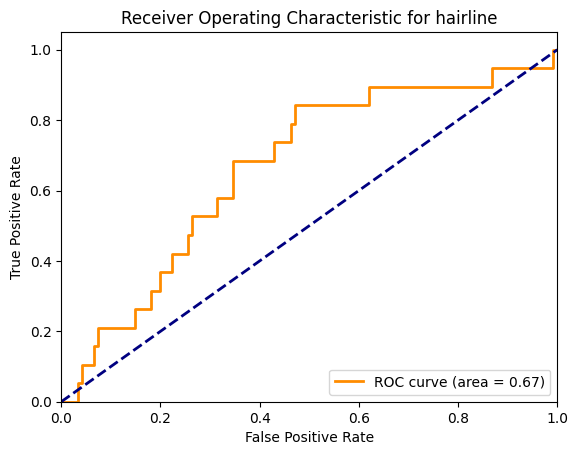

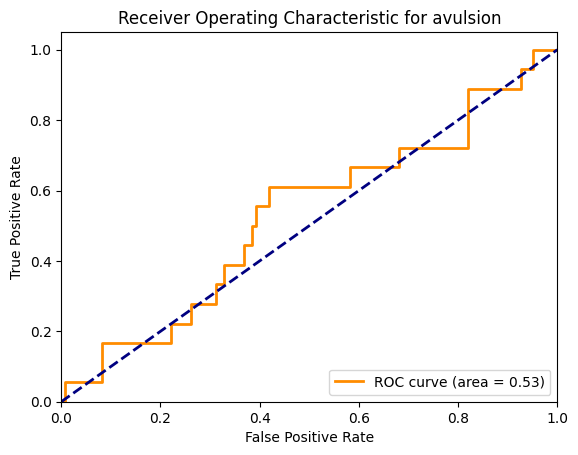

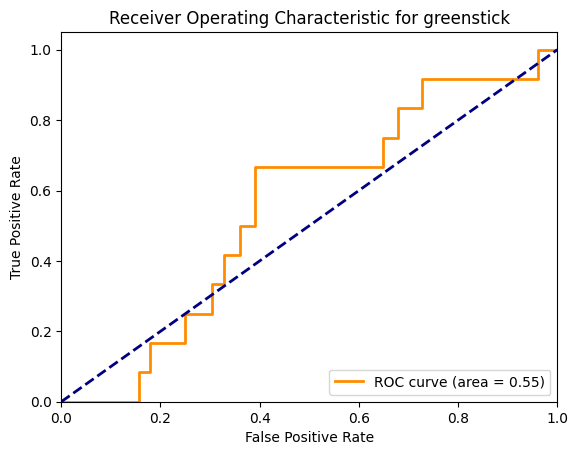

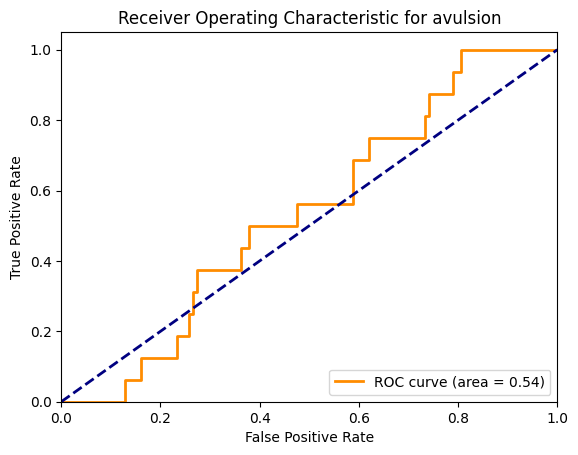

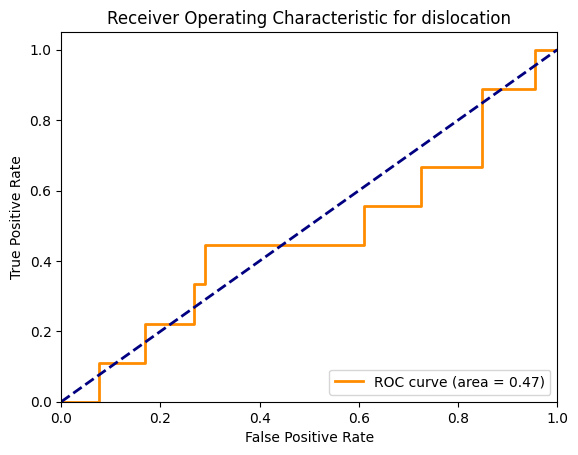

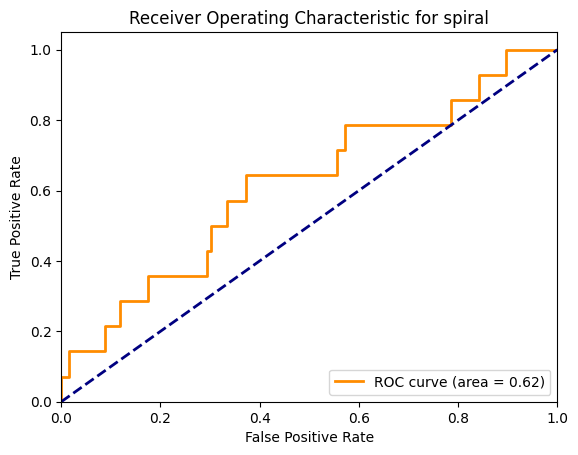

Accuracy: 0.17857142857142858
Classification Report:


,precision,recall,f1-score,support
oblique,0.181818,0.400000,0.250000,10.000000
impacted,0.000000,0.000000,0.000000,12.000000
hairline,0.185185,0.312500,0.232558,16.000000
impacted,0.285714,0.285714,0.285714,14.000000
hairline,0.250000,0.315789,0.279070,19.000000
avulsion,0.214286,0.166667,0.187500,18.000000
greenstick,0.000000,0.000000,0.000000,12.000000
avulsion,0.000000,0.000000,0.000000,16.000000
dislocation,0.000000,0.000000,0.000000,9.000000
spiral,0.272727,0.214286,0.240000,14.000000


In [20]:
y_pred = model.predict(pca_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report.index = report.index.map(lambda x: class_lookup[int(x)] if x.isdigit() else x)

test_confusion_matrix = confusion_matrix(y_test, y_pred)
show_confusion_matrix(test_confusion_matrix)

y_score = model.predict_proba(pca_test)
show_roc_curve(y_score, y_test)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
report

## Model 7: Best Combination

In [21]:
X_train = np.hstack((images_train, hog_train))
X_test = np.hstack((images_test, hog_test))


In [22]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'multi_class': ['multinomial', 'ovr'],
    'penalty': ['l2']
}

lr = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1000)
rand_search = RandomizedSearchCV(estimator=lr, param_distributions=param_grid, cv=3, n_jobs=-1, n_iter=3, scoring='accuracy', random_state=42)
start_time = time.time()
rand_search.fit(X_train, y_train)
training_time = time.time() - start_time
print(f"Best parameters: {rand_search.best_params_}")
print(f"Best score: {rand_search.best_score_}")
print(f"Training time: {training_time:.2f} seconds")


In [ ]:
model = rand_search.best_estimator_
start_time = time.time()
y_pred = model.predict(X_test)
inference_time = time.time() - start_time
print(f"Inference time: {inference_time:.2f} seconds")

/home/davidsolow/.pyenv/versions/3.11.1/envs/fracture-classification/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/davidsolow/.pyenv/versions/3.11.1/envs/fracture-classification/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/davidsolow/.pyenv/versions/3.11.1/envs/fracture-classification/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use 

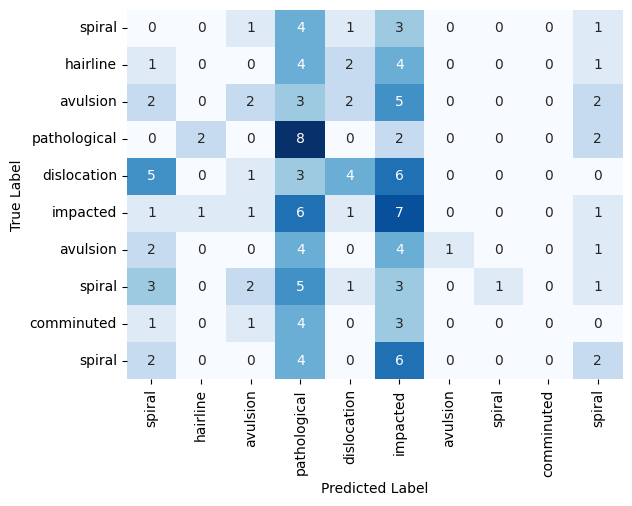

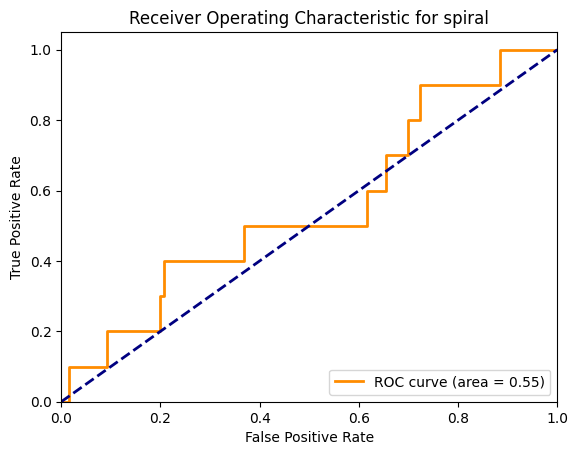

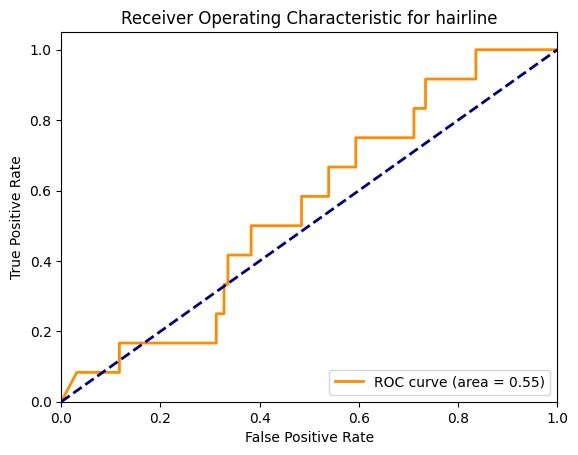

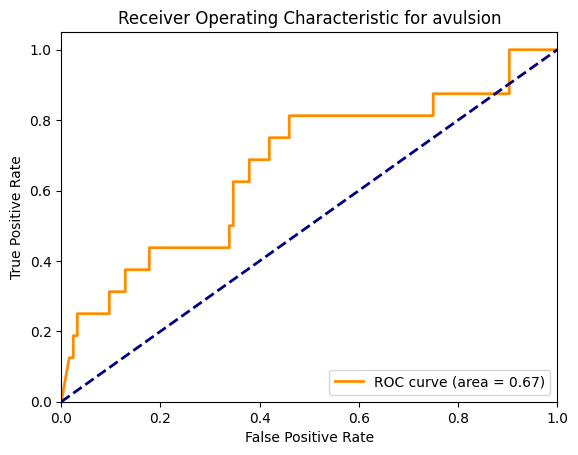

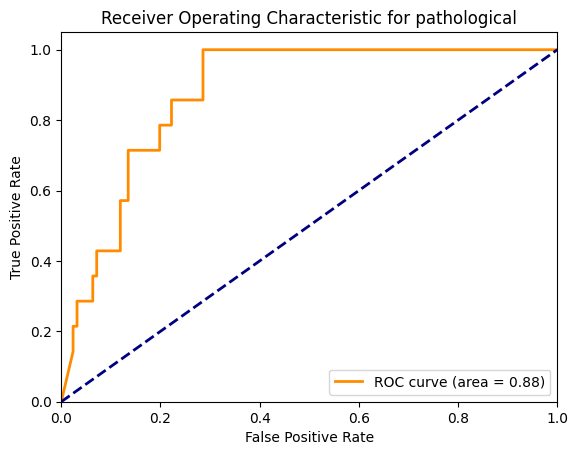

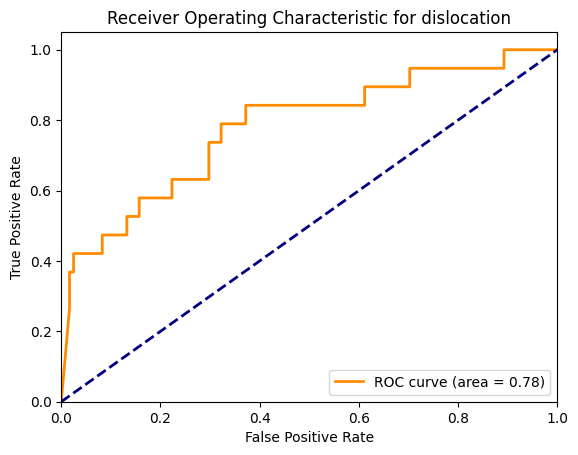

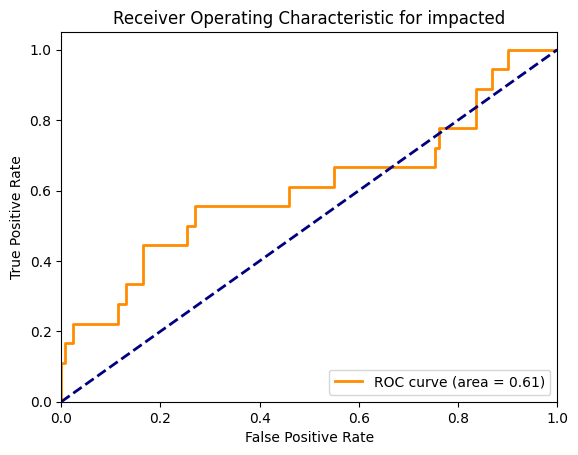

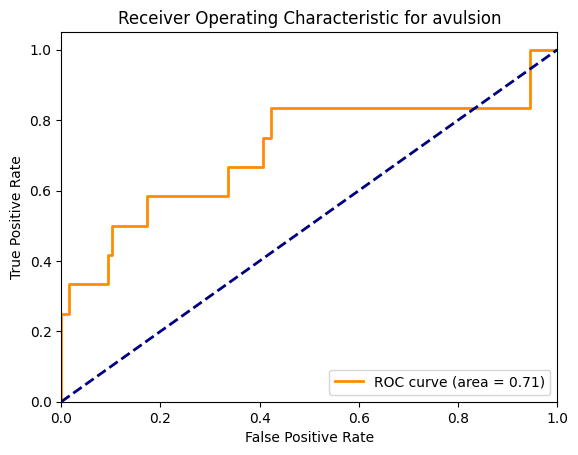

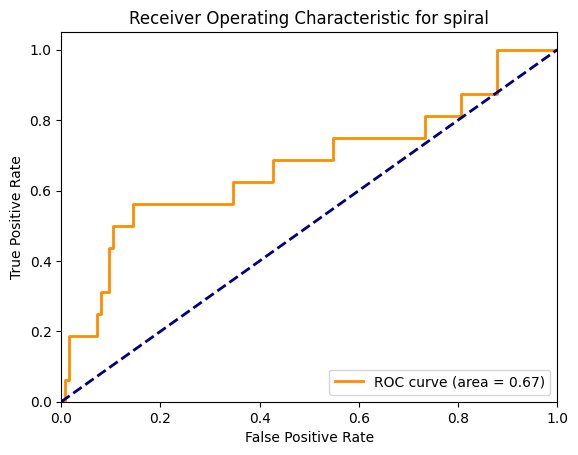

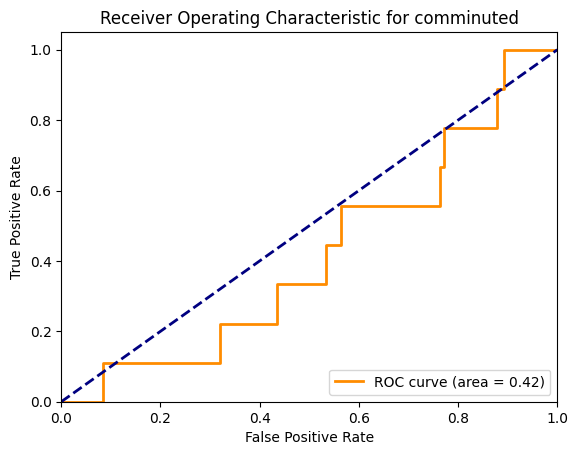

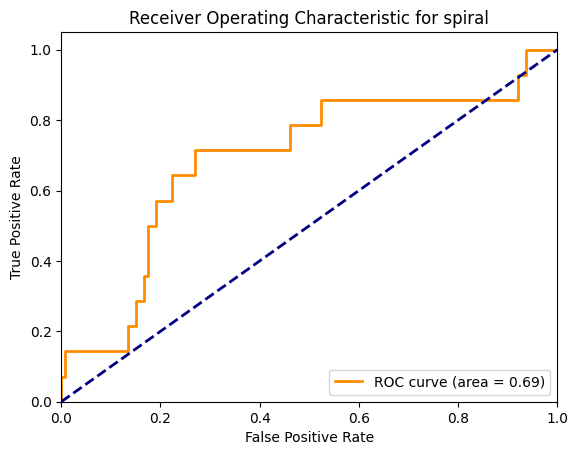

Accuracy: 0.2642857142857143
Classification Report:


,precision,recall,f1-score,support
spiral,0.000000,0.000000,0.000000,10.000000
hairline,0.000000,0.000000,0.000000,12.000000
avulsion,0.250000,0.125000,0.166667,16.000000
pathological,0.177778,0.571429,0.271186,14.000000
dislocation,0.363636,0.210526,0.266667,19.000000
impacted,0.162791,0.388889,0.229508,18.000000
avulsion,1.000000,0.083333,0.153846,12.000000
spiral,1.000000,0.062500,0.117647,16.000000
comminuted,0.000000,0.000000,0.000000,9.000000
spiral,0.181818,0.142857,0.160000,14.000000


In [ ]:
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report.index = report.index.map(lambda x: class_lookup[int(x)] if x.isdigit() else x)

test_confusion_matrix = confusion_matrix(y_test, y_pred)
show_confusion_matrix(test_confusion_matrix)

y_score = model.predict_proba(X_test)
show_roc_curve(y_score, y_test)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
report
